In [3]:
import pandas as pd
import numpy as np
import sklearn

In [4]:
netflix = pd.read_csv('../data/final_data/netflix_final_data.csv')

In [7]:
ratings = pd.read_csv('../data/raw/title.ratings.tsv', sep='\t')

basics = pd.read_csv('../data/raw/title.basics.tsv', sep='\t', usecols=['tconst', 'titleType', 'isAdult', 'runtimeMinutes', 'genres'])


C:\Users\Joeyz\AppData\Local\Temp\ipykernel_26796\2180540322.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  basics = pd.read_csv('../data/raw/title.basics.tsv', sep='\t', usecols=['tconst', 'titleType', 'isAdult', 'runtimeMinutes', 'genres'])


In [8]:
df = netflix.merge(ratings, how='left', on='tconst').merge(basics, how='left', on='tconst', )

Let's first drop the 1 row that has no tconst, meaning it could not be found on IMDB.

In [9]:
#df.isna().sum()
df = df[df['tconst'].notna()]

Change is_top_10 into int

In [60]:
df['is_top10'] = df['is_top10'].astype(int)

replace \N with nan

In [74]:
df.replace('\\N', np.nan, inplace=True)

Split into movies and tv_shows, since I think they are too different to combine into 1 model

In [75]:
movies, tv_shows = df[df['is_tv_show']==False], df[df['is_tv_show']==True]

## Movies

Drop columns, remove rows with >1 NaN entry

In [76]:
# drop columns that are not needed
movies = movies.drop(['tconst', 'combined_title', 'title', 'season', 'is_tv_show'], axis = 1)

# remove any rows with > 1 NaN entry
rowWiseNullCounter = pd.DataFrame(movies.isnull().sum(axis = 1))
indexRowsToRemove1 = list(rowWiseNullCounter[rowWiseNullCounter[0] >= 1].index.values)

for i in indexRowsToRemove1:
    movies.drop(index = i, axis = 1, inplace = True)

movies = movies.reset_index(drop = True)

Now make train and test sets

In [131]:
from sklearn.model_selection import train_test_split

In [132]:
movies_train, movies_test = train_test_split(movies, test_size=0.3, random_state=42)

In [133]:
movies_train_X = movies_train.drop(['is_top10'], axis = 1)
movies_train_Y = movies_train['is_top10']

movies_test_X = movies_test.drop(['is_top10'], axis = 1)
movies_test_Y = movies_test['is_top10']

I want to first one hot encode titleType, and turn genres into bag of words matrix.

impute the missing ratings data, then turn genres into a bag of words matrix

In [134]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer

In [135]:
from sklearn.compose import make_column_transformer

In [136]:
countvectorizer = make_column_transformer((CountVectorizer(), 'genres'), remainder='passthrough')

In [179]:
transformer = ColumnTransformer(
    [("onehot",OneHotEncoder(drop='first', handle_unknown='ignore'), ['titleType']),
    ("imputer", SimpleImputer(strategy='mean'), ['averageRating']),
    ("bagofw", CountVectorizer(), 'genres')
    ],
    remainder='passthrough')

In [140]:
from sklearn.pipeline import Pipeline

In [142]:
from sklearn.feature_selection import SelectFromModel

In [216]:
#make sklearn pipeline with transform, normalization, and model
pipe = Pipeline(
    steps=[
        ('transformer', transformer),
        #('feature_selection', SelectFromModel(sklearn.linear_model.LogisticRegression())),
        ('logistic_regress', sklearn.linear_model.LogisticRegression(solver='saga', max_iter=10000))
        
    ]
)

In [217]:
from sklearn.model_selection import GridSearchCV

In [224]:
gs = GridSearchCV(
    pipe,
    param_grid={
        'logistic_regress__penalty': ['elasticnet'],
        'logistic_regress__C': [0.001, 0.1, 1, 10, 100],
        'logistic_regress__l1_ratio': [0, 0.1, 0.5, 0.9, 1],
    },
    scoring={"AUC": "roc_auc", "Accuracy": "accuracy"},
    refit="AUC",
    cv=5,
    verbose=0,
    n_jobs=-1,
)

In [225]:
gs.fit(movies_train_X, movies_train_Y)

c:\ProgramData\Miniconda3\envs\netflix_proj\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('imputer',
                                                                         SimpleImputer(),
                                                                         ['averageRating']),
                                                                        ('bagofw',
                                                                         CountVectorizer(),
                                                                         'genres')])),
                                       ('logistic_regress',
                                        LogisticRegression(max_iter=10000,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'logistic_regress__C': [0.001, 0.1, 1, 10, 100],
                         'logistic_regress__l1_ratio': [0, 0.1, 0.5, 0.9, 1],
                         'logistic_regress__penalty': ['elasticnet']},
             refit='AUC', scoring={'AUC': 'roc_auc', 'Accuracy': 'accuracy'})

In [226]:
gs.best_params_

{'logistic_regress__C': 0.001,
 'logistic_regress__l1_ratio': 0.1,
 'logistic_regress__penalty': 'elasticnet'}

In [228]:
best_logistic = gs.best_estimator_

Accuracy:  0.6770186335403726
AUC:  0.6525918430884184


c:\ProgramData\Miniconda3\envs\netflix_proj\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


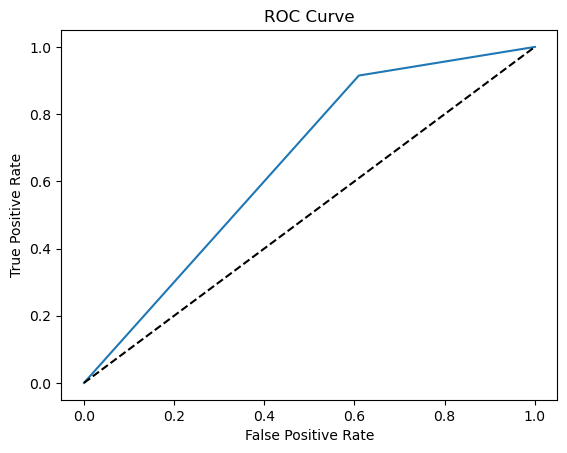

In [229]:
best_logistic.fit(movies_train_X, movies_train_Y)

from sklearn.metrics import roc_auc_score, accuracy_score

y_pred = best_logistic.predict(movies_test_X)

print("Accuracy: ", accuracy_score(movies_test_Y, y_pred))
print("AUC: ", roc_auc_score(movies_test_Y, y_pred))

#plot auc curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(movies_test_Y, y_pred)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [206]:
logistic.fit(movies_train_X, movies_train_Y)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['titleType']),
                                                 ('imputer', SimpleImputer(),
                                                  ['averageRating']),
                                                 ('bagofw', CountVectorizer(),
                                                  'genres')])),
                ('logistic', LogisticRegression())])

In [207]:
logistic.score(movies_train_X, movies_train_Y)

0.7062750333778371

In [208]:
logistic.score(movies_test_X, movies_test_Y)

0.6770186335403726